In [1]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

from CIFAR100_helper import *
from model import *
from common import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

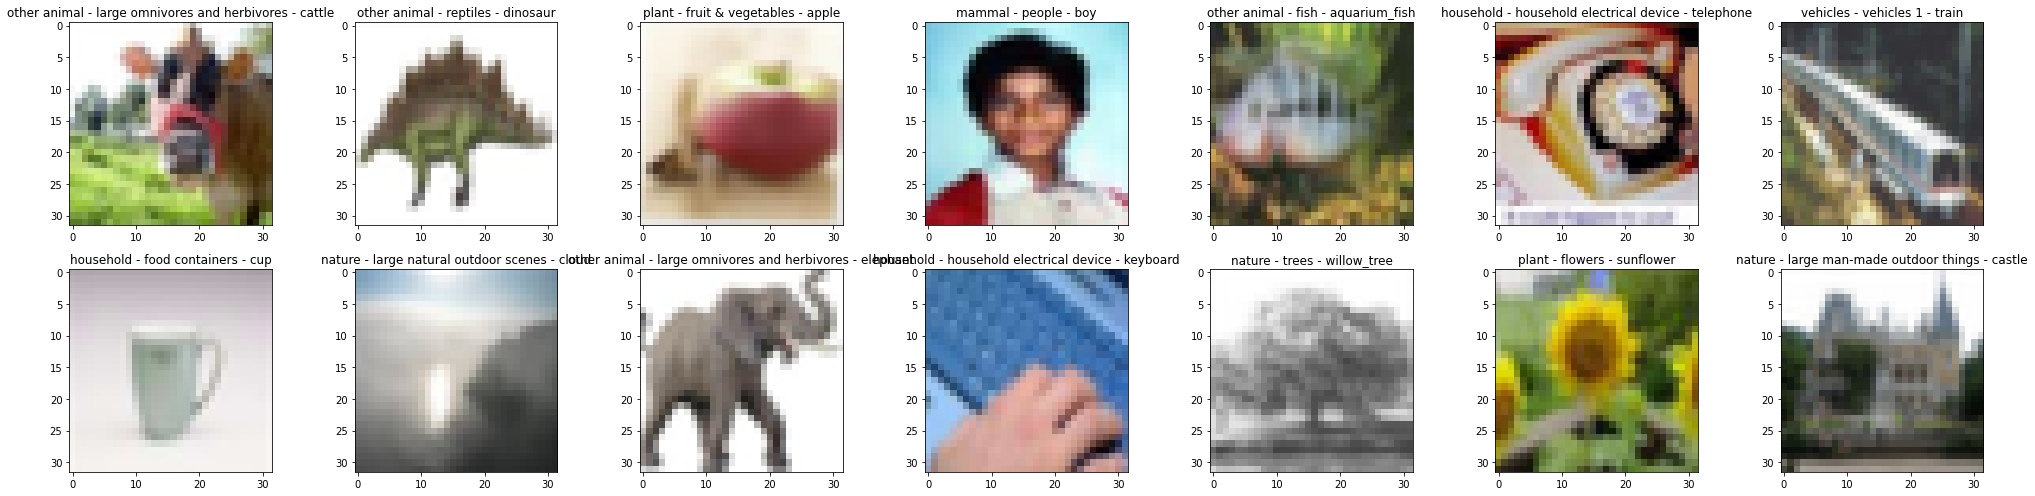

In [3]:
(x_train, y_ultra_train, y_super_train, y_sub_train), (x_test, y_ultra_test, y_super_test, y_sub_test) = get_cifar100_with_split()
plot_sample_images((x_train, y_ultra_train, y_super_train, y_sub_train), v_get_labels)

In [4]:
def create_layer(img_input, n_classes, fc_dropout=0.3, activation='relu', class_type = 'default', embedding = None, nodes = 64):
    # FC Layers
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc1')(img_input)
#     x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc2', enable_dropout=False)(x)
    if embedding is not None:
        x = tf.keras.layers.Concatenate()([x, embedding])
    output = Dense(n_classes, activation='softmax', name=f'{class_type}_output')(x)
    return output, x

In [5]:
def run_experiment(loss_weights = [0.2, 0.35, 0.45]):
    def create_model(loss_weights, plot=False):
        n_ultraclasses = 7
        n_superclasses = 20
        n_subclasses = 100
        input_shape = x_train[0].shape

        img_input = Input(shape=input_shape, name='input')

        base_layer = vgg13(img_input, conv_dropout=0.3, class_type = 'base')
        base_layer = Dropout(0.5)(base_layer)

        ultra_layer, ultra_layer_embedding = create_layer(base_layer, n_ultraclasses, class_type = 'ultra')
        super_layer, super_layer_embedding = create_layer(base_layer, n_superclasses, class_type = 'super', embedding = ultra_layer_embedding)
        sub_layer,_ = create_layer(base_layer, n_subclasses, class_type = 'sub', embedding = super_layer_embedding)

        model = keras.Model(inputs=img_input,
                     outputs = [ultra_layer, super_layer, sub_layer],
                     name="cifar100")
        if plot:
            fig = tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=75)
            display(fig)

        init_lr = 5e-4
        lr_decay = 1e-6

        opt = keras.optimizers.Adam(lr=init_lr, decay=lr_decay)

        model.compile(
            optimizer=opt,
            loss={
                'ultra_output':'categorical_crossentropy',
                'super_output':'categorical_crossentropy',
                'sub_output':'categorical_crossentropy'
            },
             metrics={
                'ultra_output':['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=int(n_ultraclasses / 10) if int(n_ultraclasses / 10) > 2 else 2)],
                'super_output':['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=int(n_superclasses / 10) if int(n_superclasses / 10) > 2 else 2)],
                'sub_output':['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=int(n_subclasses / 10) if int(n_subclasses / 10) > 2 else 2)]
            },
            loss_weights=loss_weights
        )

        return model
    
    stats =[]
#     n_splits = 5
    epochs = 50
    model = None
    model = create_model(loss_weights, False)
    stats.append(train_and_predict(model, epochs, (x_train, y_ultra_train, y_super_train, y_sub_train), (x_test, y_ultra_test, y_super_test, y_sub_test)))
    reset_keras(model)
    return stats

In [6]:
all_stats = []
all_weights =[
    [0.1, 0.2, 0.7],
    [0.1, 0.3, 0.6],
    [0.1, 0.4, 0.5],
    [0.2, 0.3, 0.5],
    [0.2, 0.4, 0.4],
    [0.2, 0.35, 0.45],
    [0.3, 0.3, 0.4],
    [0.4, 0.3, 0.3],
    [0.35, 0.35, 0.3],
]
for ratio in all_weights:
    print(f"working on ratio = {ratio}:")
    all_stats.append(run_experiment(ratio))

working on ratio = [0.1, 0.2, 0.7]:
Epoch 1/50
157/157 [==============================] - 16s 77ms/step - loss: 4.4623 - ultra_output_loss: 2.2207 - super_output_loss: 3.4016 - sub_output_loss: 5.0856 - ultra_output_accuracy: 0.2409 - ultra_output_top_k_categorical_accuracy: 0.4284 - super_output_accuracy: 0.0970 - super_output_top_k_categorical_accuracy: 0.1816 - sub_output_accuracy: 0.0273 - sub_output_top_k_categorical_accuracy: 0.2008 - val_loss: 4.3047 - val_ultra_output_loss: 1.9796 - val_super_output_loss: 3.2033 - val_sub_output_loss: 4.9516 - val_ultra_output_accuracy: 0.2012 - val_ultra_output_top_k_categorical_accuracy: 0.4012 - val_super_output_accuracy: 0.0683 - val_super_output_top_k_categorical_accuracy: 0.1175 - val_sub_output_accuracy: 0.0117 - val_sub_output_top_k_categorical_accuracy: 0.1162
Epoch 2/50
157/157 [==============================] - 10s 64ms/step - loss: 3.4262 - ultra_output_loss: 1.5868 - super_output_loss: 2.5538 - sub_output_loss: 3.9382 - ultra_outpu

In [7]:
for idx, stats in enumerate(all_stats):
    print(f"\n\nRatio = {all_weights[idx]}:")
    for i, stat in enumerate(stats):
        print(f"Fold {i + 1}: {stat}")



Ratio = [0.1, 0.2, 0.7]:
Fold 1: (0.2297, 0.3288, 0.4575, 0.07356666666666667)


Ratio = [0.1, 0.3, 0.6]:
Fold 1: (0.215, 0.3106, 0.4471, 0.06816666666666667)


Ratio = [0.1, 0.4, 0.5]:
Fold 1: (0.2093, 0.3058, 0.4497, 0.06426666666666667)


Ratio = [0.2, 0.3, 0.5]:
Fold 1: (0.2124, 0.3064, 0.4524, 0.06356666666666666)


Ratio = [0.2, 0.4, 0.4]:
Fold 1: (0.225, 0.3205, 0.4677, 0.063)


Ratio = [0.2, 0.35, 0.45]:
Fold 1: (0.2172, 0.3121, 0.4525, 0.05936666666666666)


Ratio = [0.3, 0.3, 0.4]:
Fold 1: (0.2151, 0.3135, 0.4558, 0.058066666666666676)


Ratio = [0.4, 0.3, 0.3]:
Fold 1: (0.2106, 0.3053, 0.447, 0.05316666666666666)


Ratio = [0.35, 0.35, 0.3]:
Fold 1: (0.2163, 0.3152, 0.4582, 0.053799999999999994)
